# A Network Tour of Data Science
### &nbsp; &nbsp; &nbsp; Xavier Bresson, Winter 2016/17
## Assignment 2 : Convolutional Neural Networks

In [1]:
# Import libraries
import numpy as np
import tensorflow as tf
import time
import collections
import os

import matplotlib.pyplot as plt
# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# Load small part of CIFAR dataset
[X_train, y_train, X_test, y_test] = np.load(os.path.join('datasets', 'cifar.npy'))

# Convert to float
train_data_orig = X_train.astype('float32')
y_train = y_train.astype('float32')
test_data_orig = X_test.astype('float32')
y_test = y_test.astype('float32')

# See shapes of matrices
print('Training data shape: ', train_data_orig.shape)
print('Training label shape: ', y_train.shape)
print('Test data shape: ', test_data_orig.shape)
print('Test label shape: ', y_test.shape)

Training data shape:  (2500, 32, 32, 3)
Training label shape:  (2500,)
Test data shape:  (100, 32, 32, 3)
Test label shape:  (100,)


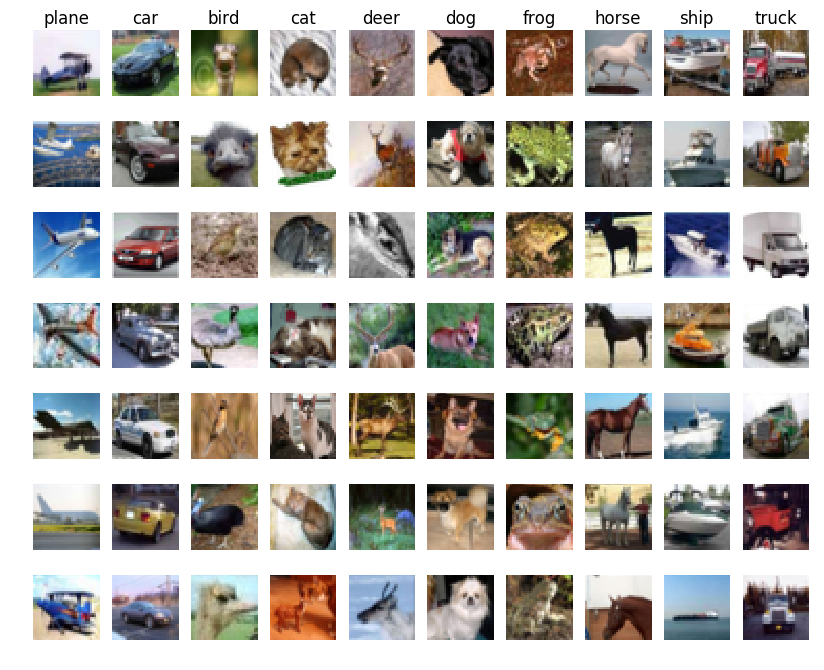

In [3]:
# Visualize a few examples of training images from each class
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        xx = train_data_orig[idx,:,:,:]
        xx -= np.min(xx)
        xx /= np.max(xx)
        plt.imshow(xx)
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Data pre-processing
n = train_data_orig.shape[0]
train_data = np.zeros([n,32**2])
for i in range(n):
    xx = train_data_orig[i,:,:,:]
    xx = np.linalg.norm(xx,axis=2)
    xx -= np.mean(xx)
    xx /= np.linalg.norm(xx)
    train_data[i] = np.reshape(xx,[-1])

n = test_data_orig.shape[0]
test_data = np.zeros([n,32**2])
for i in range(n):
    xx = test_data_orig[i,:,:,:]
    xx = np.linalg.norm(xx,axis=2)
    xx -= np.mean(xx)
    xx /= np.linalg.norm(xx)
    test_data[i] = np.reshape(xx,[-1])

print(train_data.shape)
print(test_data.shape)

(2500, 1024)
(100, 1024)


In [5]:
# Convert label values to one_hot vector
from scipy.sparse import coo_matrix
def convert_to_one_hot(a,max_val=None):
    N = a.size
    data = np.ones(N,dtype=int)
    sparse_out = coo_matrix((data,(np.arange(N),a.ravel())), shape=(N,max_val))
    return np.array(sparse_out.todense())

train_labels = convert_to_one_hot(y_train,10)
test_labels = convert_to_one_hot(y_test,10)

print(train_labels.shape)
print(test_labels.shape)

(2500, 10)
(100, 10)


# Model 1
**Question 1** Define with TensorFlow a linear classifier model:

$$
y=\textrm{softmax}(xW+b)
$$

Compute the train accuracy and the test accuracy (you should get a test accuracy around 25% at iteration 10,000)<br><br>
Hints: <br>
(1) You may use functions *tf.matmul(), tf.nn.softmax()*<br>
(2) You may use Xavier's initialization discussed during lectures for W, and b=0<br>
(3) You may use optimization schemes *tf.train.GradientDescentOptimizer(), tf.train.AdamOptimizer()*<br>

In [6]:
# Define computational graph (CG)
batch_size = 100         # batch size
d = train_data.shape[1]  # data dimensionality
nc = 10                  # number of classes

# CG inputs
xin = tf.placeholder(tf.float32,[batch_size,d]); print('xin=',xin,xin.get_shape())
y_label = tf.placeholder(tf.float32,[batch_size,nc]); print('y_label=',y_label,y_label.get_shape())

#initialize vraiables
W = tf.get_variable("W", shape=[d, nc],initializer=tf.contrib.layers.xavier_initializer())
b = tf.Variable(tf.zeros(nc))

# Fully Connected layer
y = tf.matmul(xin,W)
y += b

# Softmax
y = tf.nn.softmax(y,name=None)

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))
total_loss = cross_entropy

# Optimization scheme
train_step = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(total_loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_label,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

xin= Tensor("Placeholder:0", shape=(100, 1024), dtype=float32) (100, 1024)
y_label= Tensor("Placeholder_1:0", shape=(100, 10), dtype=float32) (100, 10)


In [7]:
# Run Computational Graph
n = train_data.shape[0]
indices = collections.deque()
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
for i in range(10001):
    
    # Batch extraction
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) 
    idx = [indices.popleft() for i in range(batch_size)]
    batch_x, batch_y = train_data[idx,:], train_labels[idx]
    #print(batch_x.shape,batch_y.shape)
    
    # Run CG for variable training
    _,acc_train,total_loss_o = sess.run([train_step,accuracy,total_loss], feed_dict={xin: batch_x, y_label: batch_y})
    
    # Run CG for test set
    if not i%1000:
        print('\nIteration i=',i,', train accuracy=',acc_train,', loss=',total_loss_o)
        acc_test = sess.run(accuracy, feed_dict={xin: test_data, y_label: test_labels})
        print('test accuracy=',acc_test)
sess.close()


Iteration i= 0 , train accuracy= 0.09 , loss= 2.30708
test accuracy= 0.1

Iteration i= 1000 , train accuracy= 0.21 , loss= 2.1295
test accuracy= 0.37

Iteration i= 2000 , train accuracy= 0.28 , loss= 2.09334
test accuracy= 0.35

Iteration i= 3000 , train accuracy= 0.28 , loss= 2.01831
test accuracy= 0.35

Iteration i= 4000 , train accuracy= 0.32 , loss= 2.02431
test accuracy= 0.36

Iteration i= 5000 , train accuracy= 0.27 , loss= 2.04805
test accuracy= 0.35

Iteration i= 6000 , train accuracy= 0.38 , loss= 1.95447
test accuracy= 0.35

Iteration i= 7000 , train accuracy= 0.33 , loss= 2.04153
test accuracy= 0.33

Iteration i= 8000 , train accuracy= 0.44 , loss= 1.83363
test accuracy= 0.33

Iteration i= 9000 , train accuracy= 0.32 , loss= 1.955
test accuracy= 0.33

Iteration i= 10000 , train accuracy= 0.42 , loss= 1.91292
test accuracy= 0.33


# Model 2
**Question 2a.** Define with TensorFlow a 2-layer neural network classifier:

$$
y=\textrm{softmax}(ReLU(xW_1+b_1)W_2+b_2)
$$

Compute the train accuracy and the test accuracy (you should be able to overfit the train set)<br>
Hint: You may use functions *tf.nn.relu()*<br><br>

**Question 2b.** Add a L2 regularization term to prevent overfitting. Compute the train accuracy and the test accuracy (you should get a test accuracy around 35%)<br>
Hints: <br>
(1) You may use functions *tf.nn.l2_loss()*<br>
(2) Do not forget the constant parameter *reg_par*: total_loss = cross_entropy + reg_par* reg_loss<br>

In [8]:
# Define computational graph (CG)
batch_size = 100         # batch size
d = train_data.shape[1]  # data dimensionality
nc = 10                  # number of classes

# CG inputs
xin = tf.placeholder(tf.float32,[batch_size,d]); #print('xin=',xin,xin.get_shape())
y_label = tf.placeholder(tf.float32,[batch_size,nc]); #print('y_label=',y_label,y_label.get_shape())

#initialize vraiables
W1 = tf.get_variable("W1", shape=[d, nc],initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.zeros(nc))
W2 = tf.get_variable("W2",shape=[d, nc],initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.zeros(nc))

# 1st Fully Connected layer
y = tf.matmul(xin,W1) + b1

# ReLU activation
y = tf.nn.relu(y)

# 2nd Fully Connected layer
y = tf.matmul(xin,W2) + b2

# Softmax
y = tf.nn.softmax(y,name=None)

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))

# L2 Regularization
reg_loss = 2*(tf.nn.l2_loss(W2) + tf.nn.l2_loss(b2) ) #-------> !!!! not sure here maybe add tf.nn.l2_loss(W1) + tf.nn.l2_loss(b1)
reg_par = 1e-3
total_loss = cross_entropy + reg_par*reg_loss

# Optimization scheme
train_step = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(total_loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_label,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [9]:
# Run Computational Graph
n = train_data.shape[0]
indices = collections.deque()
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
for i in range(10001):
    
    # Batch extraction
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) 
    idx = [indices.popleft() for i in range(batch_size)]
    batch_x, batch_y = train_data[idx,:], train_labels[idx]
    #print(batch_x.shape,batch_y.shape)
    
    # Run CG for variable training
    _,acc_train,total_loss_o = sess.run([train_step,accuracy,total_loss], feed_dict={xin: batch_x, y_label: batch_y})
    
    # Run CG for test set
    if not i%1000:
        print('\nIteration i=',i,', train accuracy=',acc_train,', loss=',total_loss_o)
        acc_test = sess.run(accuracy, feed_dict={xin: test_data, y_label: test_labels})
        print('test accuracy=',acc_test)
sess.close


Iteration i= 0 , train accuracy= 0.07 , loss= 2.32624
test accuracy= 0.08

Iteration i= 1000 , train accuracy= 0.31 , loss= 2.11609
test accuracy= 0.35

Iteration i= 2000 , train accuracy= 0.36 , loss= 2.07326
test accuracy= 0.36

Iteration i= 3000 , train accuracy= 0.35 , loss= 2.07328
test accuracy= 0.36

Iteration i= 4000 , train accuracy= 0.28 , loss= 2.13349
test accuracy= 0.35

Iteration i= 5000 , train accuracy= 0.33 , loss= 1.99535
test accuracy= 0.34

Iteration i= 6000 , train accuracy= 0.29 , loss= 2.05509
test accuracy= 0.35

Iteration i= 7000 , train accuracy= 0.29 , loss= 2.08497
test accuracy= 0.37

Iteration i= 8000 , train accuracy= 0.36 , loss= 2.04597
test accuracy= 0.38

Iteration i= 9000 , train accuracy= 0.38 , loss= 2.03716
test accuracy= 0.37

Iteration i= 10000 , train accuracy= 0.34 , loss= 2.06585
test accuracy= 0.37


<bound method BaseSession.close of <tensorflow.python.client.session.Session object at 0x124b406d8>>

# Model 3
**Question 3.** Define a convolutional neural network classifier:

$$
y=\textrm{softmax}(ReLU(x\ast W_1+b_1)W_2+b_2)
$$

Hint: You may use function *tf.nn.conv2d(x_2d, Wcl, strides=[1, 1, 1, 1], padding='SAME')* <br>
with *Wcl = tf.Variable(tf.truncated_normal([K,K,1,F], stddev=YOUR CODE HERE ))*
for the convolution operator $\ast$<br>
and *x_2d = tf.reshape(xin, [-1,32,32,1])*<br>

Compute the train accuracy and the test accuracy (you should be able to overfit the train set)<br><br>

In [10]:
# Define computational graph (CG)
batch_size = 100         # batch size
d = train_data.shape[1]  # data dimensionality
nc = 10                  # number of classes

# CG inputs
xin = tf.placeholder(tf.float32,[batch_size,d]); #print('xin=',xin,xin.get_shape())
y_label = tf.placeholder(tf.float32,[batch_size,nc]); #print('y_label=',y_label,y_label.get_shape())

x_2d = tf.reshape(xin, [-1,32,32,1])

# Convolutional layer
K = 5   # size of the patch
F = 10  # number of filters

Wcl = tf.Variable(tf.truncated_normal([K,K,1,F], stddev=0.3)) 
b1 = tf.Variable(tf.zeros(nc))
b2 = tf.Variable(tf.zeros(nc))

x = tf.nn.conv2d(x_2d, Wcl, strides=[1, 1, 1, 1], padding='SAME') + b1

# ReLU activation
x = tf.nn.relu(x)

# Fully Connected layer
nfc = 32*32*F
x = tf.reshape(x, [-1,nfc]) 
W2 = tf.Variable(tf.truncated_normal([nfc,nc],stddev=0.1))
y = tf.matmul(x,W2)+b2

# Softmax
y = tf.nn.softmax(y,name=None)

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))
total_loss = cross_entropy

# Optimization scheme
train_step = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(total_loss)
#train_step = tf.train.AdamOptimizer()
# Accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_label,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [11]:
# Run Computational Graph
n = train_data.shape[0]
indices = collections.deque()
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
for i in range(10001):
    
    # Batch extraction
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) 
    idx = [indices.popleft() for i in range(batch_size)]
    batch_x, batch_y = train_data[idx,:], train_labels[idx]
    #print(batch_x.shape,batch_y.shape)
    
    # Run CG for variable training
    _,acc_train,total_loss_o = sess.run([train_step,accuracy,total_loss], feed_dict={xin: batch_x, y_label: batch_y})
    
    # Run CG for test set
    if not i%1000:
        print('\nIteration i=',i,', train accuracy=',acc_train,', loss=',total_loss_o)
        acc_test = sess.run(accuracy, feed_dict={xin: test_data, y_label: test_labels})
        print('test accuracy=',acc_test)


Iteration i= 0 , train accuracy= 0.14 , loss= 2.26979
test accuracy= 0.12

Iteration i= 1000 , train accuracy= 0.47 , loss= 1.61225
test accuracy= 0.39

Iteration i= 2000 , train accuracy= 0.59 , loss= 1.30688
test accuracy= 0.46

Iteration i= 3000 , train accuracy= 0.8 , loss= 0.832867
test accuracy= 0.45

Iteration i= 4000 , train accuracy= 0.81 , loss= 0.572148
test accuracy= 0.46

Iteration i= 5000 , train accuracy= 0.95 , loss= 0.389654
test accuracy= 0.46

Iteration i= 6000 , train accuracy= 0.98 , loss= 0.236736
test accuracy= 0.45

Iteration i= 7000 , train accuracy= 0.99 , loss= 0.183503
test accuracy= 0.44

Iteration i= 8000 , train accuracy= 1.0 , loss= 0.0982284
test accuracy= 0.45

Iteration i= 9000 , train accuracy= 1.0 , loss= 0.0696574
test accuracy= 0.45

Iteration i= 10000 , train accuracy= 1.0 , loss= 0.0537605
test accuracy= 0.44


# Model 4
**Question 4.** Regularize the previous convolutional neural network classifier:

$$
y=\textrm{softmax}(ReLU(x\ast W_1+b_1)W_2+b_2)
$$

with the dropout technique discussed during lectures.

Hint: You may use function *tf.nn.dropout()* with probability around 0.25. <br>

Compute the train accuracy and the test accuracy (you should get a test accuracy of 45%)<br>
Note: It is not mandatory to achieve 40% (as quality may change depending on initialization), but it is essential to implement correctly the classifier.<br><br>

In [12]:
# Define computational graph (CG)
batch_size = 100         # batch size
d = train_data.shape[1]  # data dimensionality
nc = 10                  # number of classes

# CG inputs
xin = tf.placeholder(tf.float32,[batch_size,d]); #print('xin=',xin,xin.get_shape())
y_label = tf.placeholder(tf.float32,[batch_size,nc]); #print('y_label=',y_label,y_label.get_shape())
d = tf.placeholder(tf.float32);

x_2d = tf.reshape(xin, [-1,32,32,1])

# Convolutional layer
K = 5   # size of the patch
F = 10  # number of filters

Wcl = tf.Variable(tf.truncated_normal([K,K,1,F], stddev=0.3)) 
b1 = tf.Variable(tf.zeros(nc))
b2 = tf.Variable(tf.zeros(nc))

x = tf.nn.conv2d(x_2d, Wcl, strides=[1, 1, 1, 1], padding='SAME') + b1

# ReLU activation
x = tf.nn.relu(x)

# Dropout
x = tf.nn.dropout(x,d)

# Fully Connected layer
nfc = 32*32*F
x = tf.reshape(x, [-1,nfc]) 
W2 = tf.Variable(tf.truncated_normal([nfc,nc],stddev=0.1))
y = tf.matmul(x,W2)+b2

# Softmax
y = tf.nn.softmax(y,name=None)

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))
total_loss = cross_entropy

# Optimization scheme
train_step = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(total_loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_label,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [13]:
# Run Computational Graph
n = train_data.shape[0]
indices = collections.deque()
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
for i in range(10001):
    
    # Batch extraction
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) 
    idx = [indices.popleft() for i in range(batch_size)]
    batch_x, batch_y = train_data[idx,:], train_labels[idx]
    #print(batch_x.shape,batch_y.shape)
    
    # Run CG for variable training
    _,acc_train,total_loss_o = sess.run([train_step,accuracy,total_loss], feed_dict={xin: batch_x, y_label: batch_y, d: 0.25})
    
    # Run CG for test set
    if not i%1000:
        print('\nIteration i=',i,', train accuracy=',acc_train,', loss=',total_loss_o)
        acc_test = sess.run(accuracy, feed_dict={xin: test_data, y_label: test_labels, d: 1.0})
        print('test accuracy=',acc_test)


Iteration i= 0 , train accuracy= 0.1 , loss= 2.42845
test accuracy= 0.07

Iteration i= 1000 , train accuracy= 0.26 , loss= 2.17195
test accuracy= 0.27

Iteration i= 2000 , train accuracy= 0.3 , loss= 1.94705
test accuracy= 0.35

Iteration i= 3000 , train accuracy= 0.38 , loss= 1.83502
test accuracy= 0.35

Iteration i= 4000 , train accuracy= 0.4 , loss= 1.76157
test accuracy= 0.41

Iteration i= 5000 , train accuracy= 0.45 , loss= 1.65763
test accuracy= 0.44

Iteration i= 6000 , train accuracy= 0.51 , loss= 1.31213
test accuracy= 0.47

Iteration i= 7000 , train accuracy= 0.54 , loss= 1.32176
test accuracy= 0.43

Iteration i= 8000 , train accuracy= 0.57 , loss= 1.27065
test accuracy= 0.47

Iteration i= 9000 , train accuracy= 0.62 , loss= 1.11654
test accuracy= 0.45

Iteration i= 10000 , train accuracy= 0.55 , loss= 1.30451
test accuracy= 0.47
